## Bangkit Final Project: Aksara Jawa Classification with Machine Learning

## Dependencies


In [0]:
# Install dependencies

!pip install -q kaggle
!pip install keras==2.3.0

     |████████████████████████████████| 378kB 8.6MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [1]:
import keras,os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Colab library to upload files to notebook
from google.colab import files

Using TensorFlow backend.


In [0]:
# Upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

## Data Preparation


In [3]:
%%time
# Download dataset from upstream
!kaggle datasets download -d phiard/aksara-jawa

 94% 174M/186M [00:01<00:00, 107MB/s] 
100% 186M/186M [00:01<00:00, 107MB/s]
CPU times: user 25.6 ms, sys: 5.65 ms, total: 31.3 ms
Wall time: 4.77 s


In [4]:
%%time
# Unzip dataset into a folder
!unzip aksara-jawa.zip -d dataset

Archive:  aksara-jawa.zip
  inflating: dataset/dataset/newtesting/ba/ba178.pred.png  
  inflating: dataset/dataset/newtesting/ba/ba198.pred.png  
  inflating: dataset/dataset/newtesting/ba/ba218.pred.png  
  inflating: dataset/dataset/newtesting/ca/ca163.pred.png  
  inflating: dataset/dataset/newtesting/ca/ca183.pred.png  
  inflating: dataset/dataset/newtesting/ca/ca203.pred.png  
  inflating: dataset/dataset/newtesting/da/da166.pred.png  
  inflating: dataset/dataset/newtesting/da/da186.pred.png  
  inflating: dataset/dataset/newtesting/da/da206.pred.png  
  inflating: dataset/dataset/newtesting/dha/dha172.pred.png  
  inflating: dataset/dataset/newtesting/dha/dha192.pred.png  
  inflating: dataset/dataset/newtesting/dha/dha212.pred.png  
  inflating: dataset/dataset/newtesting/ga/ga177.pred.png  
  inflating: dataset/dataset/newtesting/ga/ga197.pred.png  
  inflating: dataset/dataset/newtesting/ga/ga217.pred.png  
  inflating: dataset/dataset/newtesting/ha/ha161.pred.png  
  inflat

In [48]:
# Do the image augmentation and rescale image
train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    directory="/content/dataset/newdatasetaug/newtraining",
    target_size=(112,112),
    color_mode="grayscale",
    batch_size=20)

validation_data = validation_datagen.flow_from_directory(
    directory="/content/dataset/newdatasetaug/newtesting",
    target_size=(112,112),
    color_mode="grayscale",
    batch_size=20)

Found 1441 images belonging to 20 classes.
Found 839 images belonging to 20 classes.


## Build the Model



In [0]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam

In [50]:
model=Sequential()    
   
model.add(Conv2D(32,(5,5),padding='same',input_shape=(112,112,1)))
model.add(LeakyReLU(alpha=.02))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(Conv2D(196,(5,5)))
model.add(LeakyReLU(alpha=.02))    
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(.2))

model.add(GlobalMaxPooling2D())   
model.add(Dense(1024))

model.add(LeakyReLU(alpha=.02))
model.add(Dropout(.5))   

model.add(Dense(20))
model.add(Activation('softmax'))    

# Compile the model
opt = Adam(lr=0.0001)
model.compile(optimizer=opt,
              loss=keras.losses.categorical_crossentropy, 
              metrics=['accuracy'])

model.summary()

checkpoint = ModelCheckpoint("test_model.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=20, 
                      verbose=1, 
                      mode='auto')

hist = model.fit_generator(steps_per_epoch=50,
                           generator=train_data, 
                           validation_data= validation_data, 
                           validation_steps=5,
                           epochs=50,
                           callbacks=[checkpoint,early])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 112, 112, 32)      832       
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 52, 52, 196)       156996    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 52, 52, 196)       0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 26, 26, 196)     

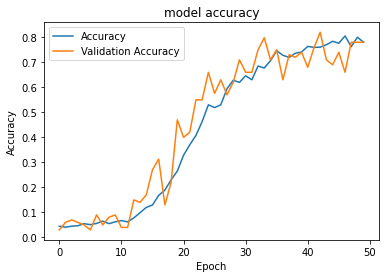

In [51]:
import matplotlib.pyplot as plt

""" Plot the accuracy"""
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

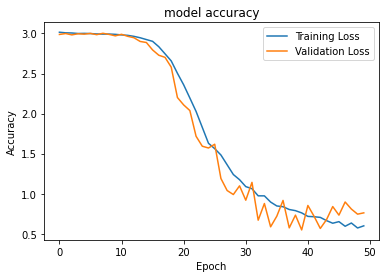

In [52]:
""" Plot the Loss"""
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training Loss","Validation Loss"])
plt.show()

## Save model to json

In [0]:
!pip install h5py

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open("model_dummy.json", "w") as json_file:
    json_file.write(model_json)